In [1]:
import geopandas as gpd
import pandas as pd
import os
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from shapely.geometry import Point
from pyproj import Transformer
import pystac_client
from pystac_client.stac_api_io import StacApiIO
import planetary_computer
import leafmap

In [2]:
config_path = '/home/benchuser/code/config.yml'
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
        
version = config['dataset']['version']
# version = 'v0.40.2'
working_dir = Path(config['directory']['working'])
output_dir = Path(config['directory']['output'])
aoi_version = config['aoi']['version']

print(yaml.dump(config))

aoi:
  exclude_indices: null
  include_indices: null
  version: v0.30
chips:
  chip_size: 960
  sample_size: 960
dataset:
  version: v0.40.5
dem:
  collection: cop-dem-glo-30
  dtype: float32
  fill_na: false
  na_value: -999
  native_crs: false
  resolution: 30
  year: 2021-01-02/2021-12-31
directory:
  output: /home/benchuser/final_data
  working: /home/benchuser/data
land_cover:
  collection: io-lulc-annual-v02
  dtype: int8
  fill_na: false
  na_value: 0
  native_crs: false
  resolution: 10
  sampling_factor: null
  year: 2023-01-02/2023-12-31
landsat:
  bands:
  - coastal
  - blue
  - green
  - red
  - nir08
  - swir16
  - swir22
  - qa_pixel
  cloud_band: qa_pixel
  cloud_cover: 100
  collection: landsat-c2-l2
  delta_days: 91
  dtype: float32
  fill_na: false
  na_value: -999
  native_crs: false
  platforms:
  - landsat-8
  - landsat-9
  resolution: 30
log_errors: true
sentinel_1:
  bands:
  - vv
  - vh
  collection: sentinel-1-rtc
  delta_days: 12
  dtype: float32
  fill_na: fa

In [3]:
metadata_filepath = Path(working_dir / version / 'chip_metadata.csv')

In [4]:
chip_df = pd.read_csv(metadata_filepath)

In [5]:
aoi_gdf = gpd.read_file(Path(working_dir) / version / 'aoi_metadata.geojson')
aoi_gdf['centroid'] = aoi_gdf.centroid
aoi_gdf.geometry = aoi_gdf['centroid']
print(Path(working_dir) / version / 'aoi_metadata.geojson')

/home/benchuser/data/v0.40.5/aoi_metadata.geojson


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/gfm_bench/share/proj failed


In [6]:
aoi_gdf[aoi_gdf['status'] == 'success']

,status,geometry,centroid
1,success,"POLYGON ((32.20688 25.3737, 32.20688 25.03055,...",POINT (32.55414 25.20213)
3,success,"POLYGON ((34.42561 -10.03493, 34.42561 -10.279...",POINT (34.55614 -10.15722)
4,success,"POLYGON ((52.39467 29.99571, 52.39467 29.8322,...",POINT (52.51323 29.91395)
5,success,"POLYGON ((28.56418 53.66322, 28.56418 53.39259...",POINT (28.8076 53.5279)
6,success,"POLYGON ((-67.12389 -18.63198, -67.12389 -19.0...",POINT (-66.8506 -18.85089)
8,success,"POLYGON ((88.11502 35.0052, 88.11502 34.64955,...",POINT (88.35167 34.82737)
10,success,"POLYGON ((116.54691 -32.41634, 116.54691 -32.7...",POINT (116.76996 -32.5647)
11,success,"POLYGON ((100.37359 15.19269, 100.37359 15.057...",POINT (100.46535 15.12507)
13,success,"POLYGON ((31.20416 30.06061, 31.20416 30.02337...",POINT (31.2423 30.04199)
14,success,"POLYGON ((28.84774 41.04137, 28.84774 41.00724...",POINT (28.88606 41.0243)


In [7]:
aoi_gdf

,status,geometry,centroid
0,Assigning CRS to a GeoDataFrame without a geom...,"POLYGON ((13.54303 24.63448, 13.54303 24.5292,...",POINT (13.61619 24.58184)
1,success,"POLYGON ((32.20688 25.3737, 32.20688 25.03055,...",POINT (32.55414 25.20213)
2,s2 scenes missing,"POLYGON ((23.10769 -11.78238, 23.10769 -11.873...",POINT (23.15997 -11.82798)
3,success,"POLYGON ((34.42561 -10.03493, 34.42561 -10.279...",POINT (34.55614 -10.15722)
4,success,"POLYGON ((52.39467 29.99571, 52.39467 29.8322,...",POINT (52.51323 29.91395)
...,...,...,...
373,not processed,"POLYGON ((-73.62022 45.57931, -73.62022 45.541...",POINT (-73.59011 45.5604)
374,not processed,"POLYGON ((-52.73406 47.56979, -52.73406 47.550...",POINT (-52.71739 47.56037)
375,not processed,"POLYGON ((-75.20969 20.14866, -75.20969 20.146...",POINT (-75.20858 20.14756)
376,not processed,"POLYGON ((-79.96607 22.40669, -79.96607 22.402...",POINT (-79.96356 22.40449)


In [8]:
aoi_colors = {
    "dem_scenes_missing": "grey",
    "landsat_scenes_missing": "purple",
    "landsat_stack_failure": "pink",
    "lc_stack_failure": "yellow",
    "s1_scenes_missing": "blue",
    "s1_stack_failure": "lightblue",
    "s2_scenes_missing": "cyan",
    "success": "green",
    "uncategorized_error": "magenta"
    
}
cmap = ListedColormap(aoi_colors.values())


KeyError: 'error'

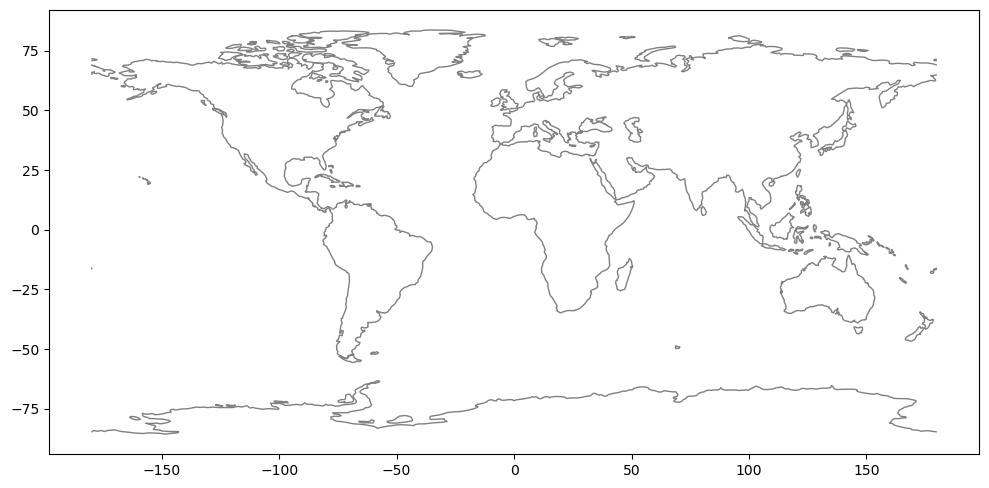

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
coastline = gpd.read_file('https://raw.githubusercontent.com/martynafford/natural-earth-geojson/refs/heads/master/110m/physical/ne_110m_coastline.json')
coastline.plot(color='grey', linewidth = 1, ax=ax)
aoi_gdf.plot('error', cmap=cmap, ax=ax, markersize=10, legend=True, legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'})
plt.tight_layout()

# Show the plot
plt.show()

In [129]:
aoi_gdf['success'] = np.where(aoi_gdf['error'] == 'success', 'success', 'failure')
booleancmap = ListedColormap(['red', 'green'])

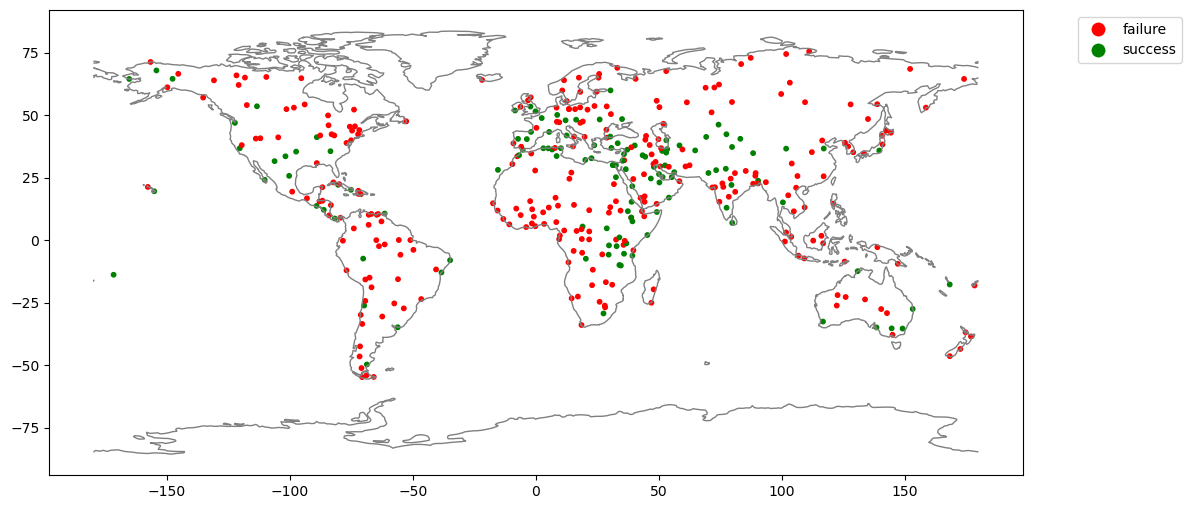

In [130]:
fig, ax = plt.subplots(figsize=(12, 8))
coastline = gpd.read_file('https://raw.githubusercontent.com/martynafford/natural-earth-geojson/refs/heads/master/110m/physical/ne_110m_coastline.json')
coastline.plot(color='grey', linewidth = 1, ax=ax)
aoi_gdf.plot('success', ax=ax, cmap = booleancmap, markersize=10, legend=True, legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'})
plt.tight_layout()

# Show the plot
plt.show()

<Axes: xlabel='error'>

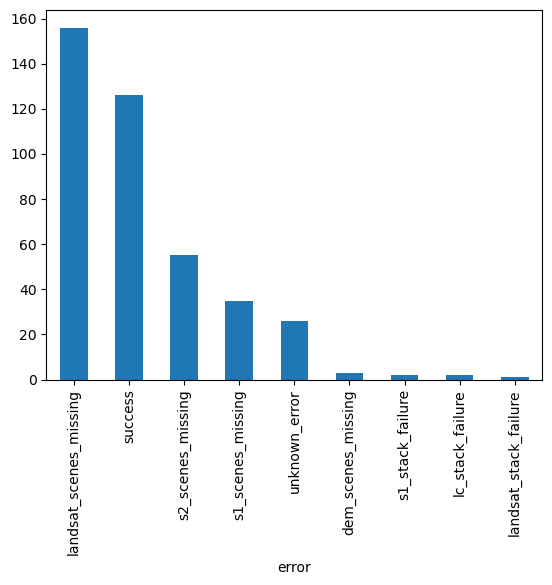

In [74]:
aoi_gdf['error'].value_counts().plot.bar()

In [194]:
len(aoi_gdf[aoi_gdf['error'] == 'success']) / len(aoi_gdf)

0.3103448275862069

In [10]:
pd.crosstab(chip_df['land_cover'], chip_df['status'], margins=True)

status,dem missing values,land_cover_11_limit,land_cover_1_limit,land_cover_2_limit,land_cover_5_limit,land_cover_8_limit,landsat missing values,sentinel_1 missing values,sentinel_2 missing values,success,All
land_cover,,,,,,,,,,,
1.0,5126,0,3913,0,0,0,5577,1,268,1069,15954
2.0,0,0,0,3079,0,0,2437,38,273,1649,7476
5.0,0,0,0,0,1880,0,2365,3,226,2480,6954
7.0,0,0,0,0,0,0,1034,2,34,558,1628
8.0,6,0,0,0,0,426,1015,0,11,957,2415
11.0,2,16868,0,0,0,0,15145,56,931,3245,36247
All,5134,16868,3913,3079,1880,426,27573,100,1743,9958,70674


In [11]:
chip_df

,chip_index,aoi_index,sentinel_2_dates,sentinel_1_dates,landsat_dates,land_cover,chip_footprint,epsg,status
0,0,4,[],[],[],11.0,"POLYGON ((39.13077690328964 9.94446335809691, ...",32637,landsat missing values
1,1,4,[],[],[],11.0,"POLYGON ((39.25338817498063 9.94439298155423, ...",32637,sentinel_2 missing values
2,2,4,[],[],[],5.0,"POLYGON ((39.46357580689312 9.944167826138123,...",32637,sentinel_2 missing values
3,3,4,[],[],[],5.0,"POLYGON ((39.56866738193475 9.9440057475879, 3...",32637,sentinel_2 missing values
4,4,4,[],[],[],5.0,"POLYGON ((39.66499959320889 9.943828188428766,...",32637,sentinel_2 missing values
...,...,...,...,...,...,...,...,...,...
71116,71116,49,"['20230221', '20230517', '20230924', '20231203']","['20230223', '20230518', '20230927', '20231208']","['20230107', '20230616', '20230920', '20231107']",11.0,"POLYGON ((51.96893962331913 35.15196237403995,...",32639,success
71117,71117,49,"['20230221', '20230517', '20230924', '20231203']","['20230223', '20230518', '20230927', '20231208']","['20230107', '20230616', '20230920', '20231107']",8.0,POLYGON ((52.05324513005312 35.151258803705396...,32639,success
71118,71118,49,"['20230221', '20230517', '20230924', '20231203']","['20230223', '20230518', '20230927', '20231208']","['20230107', '20230616', '20230920', '20231107']",8.0,POLYGON ((52.06378310940515 35.151166733971216...,32639,success
71119,71119,49,"['20230221', '20230517', '20230924', '20231203']","['20230223', '20230518', '20230927', '20231208']","['20230107', '20230616', '20230920', '20231107']",8.0,"POLYGON ((52.08485892355326 35.1509798456873, ...",32639,success


In [12]:
chip_df['aoi_index'].value_counts()

aoi_index
32    9728
40    9340
48    7244
38    7202
37    5082
5     4457
49    4069
44    3430
22    3225
21    2585
42    2441
8     1920
4     1710
45    1555
39    1494
47    1451
35    1307
16     939
14     654
15     610
17     500
33     178
Name: count, dtype: int64

In [13]:
def get_centroid_4326(row):
    transformer = Transformer.from_crs(f"EPSG:{row['epsg']}", "EPSG:4326", always_xy=True)
    lon, lat = transformer.transform(row['x_center'], row['y_center'])
    return Point(lon, lat)

In [14]:
from shapely import wkt

In [15]:
len(chip_df['chip_footprint'])

71121

In [16]:
chip_df['chip_footprint_4326'] = gpd.GeoSeries(chip_df['chip_footprint'].dropna().apply(wkt.loads), crs=4326)

In [18]:
chip_df = gpd.GeoDataFrame(chip_df, geometry = 'chip_footprint_4326', crs=4326)
chip_df['land cover and error'] = chip_df['land_cover'].astype(str) + '_' + chip_df['status']

In [19]:
aoi = 17

In [20]:
chip_df[chip_df['aoi_index'] == aoi].explore('land cover and error', tiles="http://mt0.google.com/vt/lyrs=s&hl=en&x={x}&y={y}&z={z}", attr="Google", marker_kwds=dict(radius=5))


In [21]:
import leafmap.colormaps

In [22]:
land_cover_cmap = {
    "1": "#419bdf",  # Water
    "2": "#397d49",  # Trees
    "4": "#7a87c6",  # Flooded Vegetation
    "5": "#e49635",  # Crops
    "7": "#c4281b",  # Built Area
    "8": "#a59b8f",  # Bare Ground
    "9": "#a8ebff",  # Snow/Ice
    "10": "#616161",  # Clouds
    "11": "#e3e2c3"   # Rangeland
}

In [68]:
def get_color_from_status(status: str):
    status_lc = status.split('.')[0]
    hex_color = land_cover_cmap.get(status_lc, '#000000')
    return hex_color
def get_border_from_status(status: str):
    border_color = '#66FF00' if 'success' in status else '#000000'
    return border_color

In [76]:
callback = lambda feat: {
    "color": feat['properties']['border_color'],
    "weight": 2,
    "fillColor": feat['properties']['color'],
    "fillOpacity": 1
}
m = leafmap.Map()
aoi_chips = chip_df[chip_df['aoi_index'] == aoi]
aoi_chips['color']=aoi_chips['land cover and error'].apply(lambda x: get_color_from_status(x))
aoi_chips['border_color']=aoi_chips['land cover and error'].apply(lambda x: get_border_from_status(x))
m.add_gdf(
    aoi_chips,
    style_callback=callback,
    layer_name=f"Chip Footprints (AOI {aoi})",
    zoom_to_layer=True,
)

In [71]:
stac_items = gpd.read_file(Path(working_dir) / version / f"{aoi}_stac_items.json")

Skipping field instruments: unsupported OGR type: 5
Skipping field s1:shape: unsupported OGR type: 1
Skipping field proj:bbox: unsupported OGR type: 3
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 3
Skipping field sar:polarizations: unsupported OGR type: 5


In [72]:
# initialize pystac client with retry policy
stac_api_io = StacApiIO()
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

In [73]:
supercell_ids = list(stac_items['supercell'].dropna().unique())
search = catalog.search(
    collections='io-lulc-annual-v02',
    datetime = '2023-01-02/2023-12-31',
    query = {
        'supercell' : {'in': supercell_ids}
    }
)
items = search.item_collection()

In [78]:
for item in items:
    url = item.assets['data'].href
    m.add_cog_layer(url, colormap = land_cover_cmap, zoom_to_layer=False)

In [77]:
m

Map(center=[10.342009676206672, -5.709673071014267], controls=(ZoomControl(options=['position', 'zoom_in_text'…